In [23]:
# Cargue de Librerías básicas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importar tensorflow
import tensorflow as tf
print("TF version   : ", tf.__version__)

# Necesitaremos GPU
print("GPU available: ", tf.config.list_physical_devices('GPU'))

# keras version is 2.11.0
import keras
print("Keras version   : ", keras.__version__)

TF version   :  2.15.0
GPU available:  []
Keras version   :  2.15.0


In [24]:
#--------------------------------------------#
#       debido a que estoy usando COLAB      #
#--------------------------------------------#

from google.colab import drive
drive.mount('/content/drive') #/content/drive/MyDrive/pec2/data/xl.pickle
print("GPU available: ", tf.config.list_physical_devices('GPU'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
GPU available:  []


In [25]:
import pandas as pd

home =  '/content/drive/MyDrive/TFM/'

file_path = home + "2017_2023DSTrabajo.xlsx"

dsXls = pd.read_excel(file_path)
dsXls.head(5)
dsXls.info()

####################################
# LIMPIEZA DE DATOS
####################################
#1. validar duplicados
dsXls.nunique()

#2. validar nulos, rellenar valores faltantes con la mediana
#dsXls.isnull().sum()
dsXls['Dist'].fillna(dsXls['Dist'].median(), inplace=True)
dsXls['Attendance'].fillna(dsXls['Attendance'].median(), inplace=True)
dsXls.isnull().sum()


####################################
# ESTADISTICAS
####################################
#dsXls.describe().T
dsXls.iloc[:,1:].describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4092 entries, 0 to 4091
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        4092 non-null   datetime64[ns]
 1   Round       4092 non-null   object        
 2   Day         4092 non-null   object        
 3   Venue       4092 non-null   object        
 4   Result      4092 non-null   object        
 5   GF          4092 non-null   float64       
 6   GA          4092 non-null   float64       
 7   Opponent    4092 non-null   object        
 8   xG          4092 non-null   float64       
 9   xGA         4092 non-null   float64       
 10  Poss        4092 non-null   float64       
 11  Attendance  3212 non-null   float64       
 12  Season      4092 non-null   int64         
 13  Team        4092 non-null   object        
 14  Sh          4092 non-null   float64       
 15  SoT         4092 non-null   float64       
 16  Dist        4089 non-nul

,GF,GA,xG,xGA,Poss,Attendance,Season,Sh,SoT,Dist,SCA,KP,PPA,CrsPA
count,4092.000000,4092.000000,4092.000000,4092.000000,4092.000000,4092.000000,4092.000000,4092.000000,4092.000000,4092.000000,4092.000000,4092.000000,4092.000000,4092.000000
mean,1.377810,1.377810,1.346163,1.346163,50.001222,36912.650049,2019.214076,12.317693,4.102884,17.675318,21.840176,9.215054,7.901760,1.869501
std,1.277631,1.277631,0.796551,0.796551,12.726702,15301.262664,1.566615,5.427259,2.437269,3.038064,9.897661,4.401972,4.553291,1.613642
min,0.000000,0.000000,0.000000,0.000000,18.000000,2000.000000,2017.000000,0.000000,0.000000,5.300000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.700000,0.700000,41.000000,29296.000000,2018.000000,8.000000,2.000000,15.700000,14.000000,6.000000,5.000000,1.000000
50%,1.000000,1.000000,1.200000,1.200000,50.000000,32092.500000,2019.000000,12.000000,4.000000,17.600000,21.000000,9.000000,7.000000,2.000000
75%,2.000000,2.000000,1.800000,1.800000,59.000000,51237.000000,2021.000000,16.000000,6.000000,19.500000,28.000000,12.000000,10.000000,3.000000
max,9.000000,9.000000,5.900000,5.900000,82.000000,83222.000000,2022.000000,36.000000,15.000000,35.000000,66.000000,34.000000,33.000000,12.000000


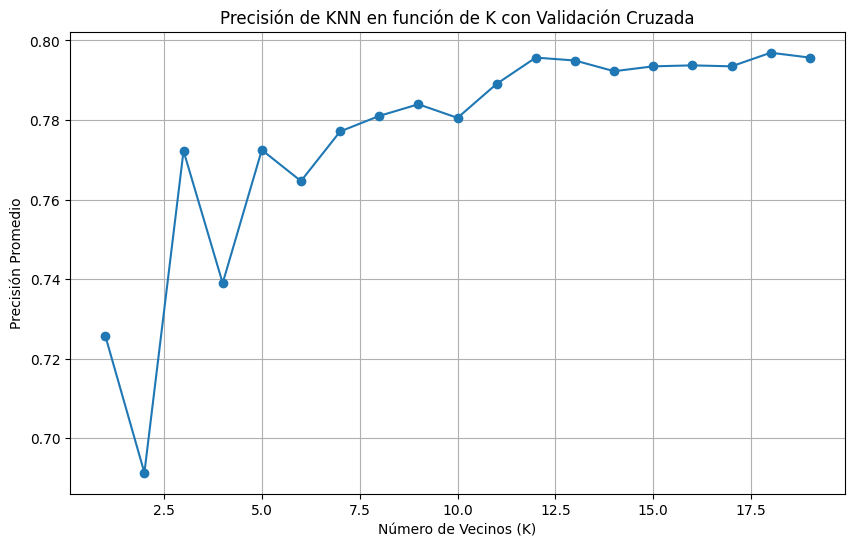

In [26]:
#BUSCAR NUMERO OPTIMO DE VECINOS
from sklearn.model_selection import cross_val_score

k_values = range(1, 20)
cross_val_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    scores = cross_val_score(knn, X_scaled, y, cv=5, scoring='accuracy')  # Usar 5-fold cross-validation
    cross_val_scores.append(scores.mean())

plt.figure(figsize=(10, 6))
plt.plot(k_values, cross_val_scores, marker='o')
plt.title('Precisión de KNN en función de K con Validación Cruzada')
plt.xlabel('Número de Vecinos (K)')
plt.ylabel('Precisión Promedio')
plt.grid(True)
plt.show()

In [27]:
# APLICAR KNN
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Selecciono columnas categóricas y numéricas
categorical_features = ['Day', 'Venue', 'Opponent']
numeric_features = ['GF', 'GA', 'xG', 'xGA', 'Poss', 'Sh', 'SoT', 'Dist', 'SCA', 'KP', 'PPA', 'CrsPA'] # no tengo en cuenta la columan date

# uso transformadores en las transformaciones de codificación y escalado
categorical_transformer = OneHotEncoder(sparse=False)
numeric_transformer = MinMaxScaler()

# Combinar transformadores
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Aplicando las transformaciones
X = dsXls.drop(['Date', 'Round', 'Result', 'Team'], axis=1)
# campo objetivo jam
y = dsXls['Result']

# Pipeline de transformaciones
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', KNeighborsClassifier(n_neighbors=10))])

# Divido los datos en entrenamiento y de prueba relacion 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar
pipeline.fit(X_train, y_train)

# Evaluando el modelo
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión de KNN: {accuracy:.2f}')

#Precision con 5 vecinos = 59%
#Precision con 2 vecinos = 47%
#Precision con 4 vecinos = 55%
#Precision con 6 vecinos = 57%
#Precision con 10 vecinos = 62%

Precisión de KNN: 0.62


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Accuracy: 0.8070818070818071


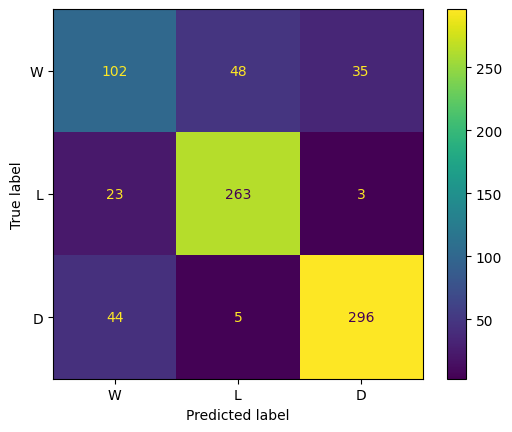

Classification Report:
               precision    recall  f1-score   support

           D       0.60      0.55      0.58       185
           L       0.83      0.91      0.87       289
           W       0.89      0.86      0.87       345

    accuracy                           0.81       819
   macro avg       0.77      0.77      0.77       819
weighted avg       0.80      0.81      0.80       819

Cross-validated Accuracy: 0.7939789863356742


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score


#y = dsXls['Result']
#X_pca = pca.fit_transform(X_scaled)

# Dividir los datos en conjuntos de entrenamiento y prueba
#X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)



X = features_scaled
y = dsXls['Result']

# Estandarización de los datos
scaler = StandardScaler()
X_scaled = pca.fit_transform(X)   #scaler.fit_transform(X)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Crear el modelo KNN con distancia Euclidiana
knn = KNeighborsClassifier(n_neighbors=13, metric='euclidean')
#10 0.7851037851037851
#8 0.7924297924297924
#5 0.7887667887667887
#2 0.7081807081807082

# Entrenar el modelo
knn.fit(X_train, y_train)

# Predecir y evaluar el modelo
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# debido a que y_pred y y_test definidos
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['W','L','D'])
disp.plot()
plt.show()

# Reporte de clasificación
print("Classification Report:\n", classification_report(y_test, y_pred))

# Validación cruzada
cross_val_accuracy = cross_val_score(knn, X_scaled, y, cv=13, scoring='accuracy')
print("Cross-validated Accuracy:", cross_val_accuracy.mean())
